In [6]:
import sys
# Use cloned repo not pip - will make changes to the library
sys.path[0] = 'd:\\DesktopHDD\\PhD Courses\\ECCE 794\\RL\\Project\\mobile-env'

In [7]:
import gymnasium
import matplotlib.pyplot as plt
# importing mobile_env automatically registers the predefined scenarios in Gym
import mobile_env
from IPython import display

# create a small mobile environment for a single, centralized control agent
# pass rgb_array as render mode so the env can be rendered inside the notebook
env = gymnasium.make("mobile-small-central-v0", render_mode="rgb_array")

print(f"\nSmall environment with {env.NUM_USERS} users and {env.NUM_STATIONS} cells.")


Small environment with 5 users and 3 cells.


D:\Lib\site-packages\gymnasium\utils\passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


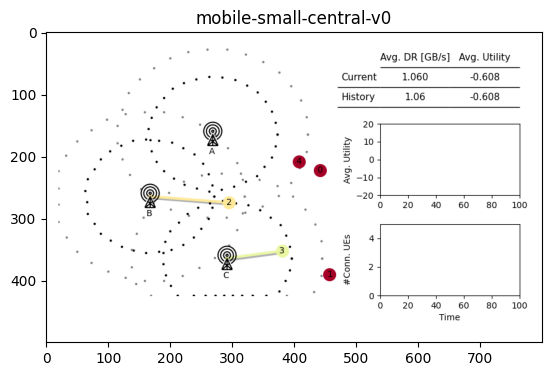

In [8]:
# predefined small scenarios
from mobile_env.scenarios.small import MComSmall

# easy access to the default configuration
MComSmall.default_config()
def plot_env(env_name):
    """Create env, take a random step, and then render the environment."""
    env = gymnasium.make(env_name, render_mode="rgb_array")
    env.reset()
    env.step(env.action_space.sample())
    plt.imshow(env.render())
    plt.title(env_name)

# plot small env from earlier
plot_env("mobile-small-central-v0")

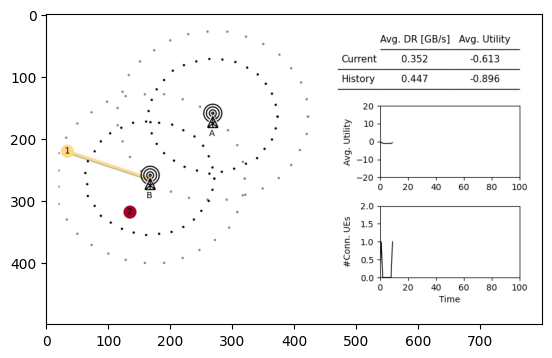

In [9]:
from mobile_env.core.base import MComCore
from mobile_env.core.entities import BaseStation, UserEquipment


class CustomEnv1(MComCore):
    # overwrite the default config
    @classmethod
    def default_config(cls):
        config = super().default_config()
        config.update({
            "seed": 1534,
            'reset_rng_episode': True,
        })
        return config

    # configure users and cells in the constructor
    def __init__(self, config={}, render_mode=None):
        # load default config defined above; overwrite with custom params
        env_config = self.default_config()
        env_config.update(config)

        # two cells next to each other; unpack config defaults for other params
        stations = [
            BaseStation(bs_id=0, pos=(110, 130), **env_config["bs"]),
            BaseStation(bs_id=1, pos=(65, 80), **env_config["bs"])
        ]

        # users
        users = [
            # two fast moving users with config defaults
            UserEquipment(ue_id=1, velocity=0, snr_tr=env_config["ue"]["snr_tr"], noise=env_config["ue"]["noise"],
                          height=env_config["ue"]["height"]),
            # stationary user --> set velocity to 0
            UserEquipment(ue_id=2, velocity=0, snr_tr=env_config["ue"]["snr_tr"], noise=env_config["ue"]["noise"],
                          height=env_config["ue"]["height"]),
        ]

        super().__init__(stations, users, config, render_mode)

class CustomEnv2(MComCore):
    # overwrite the default config
    @classmethod
    def default_config(cls):
        config = super().default_config()
        config.update({
            "seed": 1534,
            'reset_rng_episode': True,
        })
        # faster user movement
        config["ue"].update({
            "velocity": 10,
        })
        return config

    # configure users and cells in the constructor
    def __init__(self, config={}, render_mode=None):
        # load default config defined above; overwrite with custom params
        env_config = self.default_config()
        env_config.update(config)

        # two cells next to each other; unpack config defaults for other params
        stations = [
            BaseStation(bs_id=0, pos=(110, 130), **env_config["bs"]),
            BaseStation(bs_id=1, pos=(65, 80), **env_config["bs"])
        ]

        # users
        users = [
            # two fast moving users with config defaults
            UserEquipment(ue_id=1, **env_config["ue"]),
            UserEquipment(ue_id=2, **env_config["ue"]),
        ]

        super().__init__(stations, users, config, render_mode)

class CustomEnv3(MComCore):
    # overwrite the default config
    @classmethod
    def default_config(cls):
        config = super().default_config()
        config.update({
            "seed": 1534,
            'reset_rng_episode': True,
        })
        # faster user movement
        config["ue"].update({
            "velocity": 10,
        })
        return config

    # configure users and cells in the constructor
    def __init__(self, config={}, render_mode=None):
        # load default config defined above; overwrite with custom params
        env_config = self.default_config()
        env_config.update(config)

        # two cells next to each other; unpack config defaults for other params
        stations = [
            BaseStation(bs_id=0, pos=(50, 100), **env_config["bs"]),
            BaseStation(bs_id=1, pos=(100, 100), **env_config["bs"])
        ]

        # users
        users = [
            # two fast moving users with config defaults
            UserEquipment(ue_id=1, **env_config["ue"]),
            UserEquipment(ue_id=2, **env_config["ue"]),
        ]

        super().__init__(stations, users, config, render_mode)


# init and render the custom scenario
env = CustomEnv1(render_mode="rgb_array")
env.reset()
for _ in range(10):
    # here, use random dummy actions by sampling from the action space
    dummy_action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(dummy_action)

    # render the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [10]:
obs, info = env.reset(seed=42)
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

print("Raw observations: ", obs)

# connections and SNR are per user and station, utility just per user
obs_per_user = 2 * env.NUM_STATIONS + 1
for ue in range(env.NUM_USERS):
    print(f"\nObservations for user {ue + 1}:")
    offset = ue * obs_per_user
    print(f"Current connections to the {env.NUM_STATIONS} cells: {obs[offset:offset+env.NUM_STATIONS]}")
    print(f"SNR to the {env.NUM_STATIONS} cells: {obs[offset+env.NUM_STATIONS:offset+2*env.NUM_STATIONS]}")
    print(f"Current utility: {obs[offset+2*env.NUM_STATIONS]}")

Raw observations:  [ 0.          0.          1.          0.17211543 -1.          1.
  0.          0.6059607   1.          0.18099177]

Observations for user 1:
Current connections to the 2 cells: [0. 0.]
SNR to the 2 cells: [1.         0.17211543]
Current utility: -1.0

Observations for user 2:
Current connections to the 2 cells: [1. 0.]
SNR to the 2 cells: [0.6059607 1.       ]
Current utility: 0.1809917688369751


In [12]:

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

# create the custom env with the custom handler (obs space) from step 2
env = CustomEnv1()

# train PPO agent on environment. this takes a while
model = PPO(MlpPolicy, env, tensorboard_log='results_sb', verbose=1, learning_rate=0.03)
model.learn(total_timesteps=30000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to results_sb\PPO_18
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -60      |
| time/              |          |
|    fps             | 258      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 100       |
|    ep_rew_mean          | -62.4     |
| time/                   |           |
|    fps                  | 225       |
|    iterations           | 2         |
|    time_elapsed         | 18        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 3.7132483 |
|    clip_fraction        | 0.894     |
|    clip_range           | 0.2       |
|    entropy_loss

KeyboardInterrupt: 

KeyboardInterrupt: 

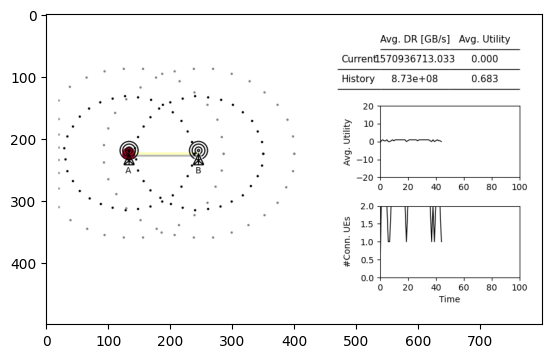

In [ ]:
env = CurriculumEnv(curriculum_step=initial_curriculum_step, render_mode="rgb_array")
obs, info = env.reset()

done = False

# run one episode with the trained model
while not done:
    action, _ = model.predict(obs)

    # perform step on simulation environment
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # render environment as RGB
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)